This used latent space of 1024 and hidden of only 512. But it seems to really struggle because of the smaller hidden space.
    

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from vae import VAE5, loss_function_vae
from helpers.summarize import TorchSummarizeDf
from helpers.dataset import load_cache_data
from rnn import MDNRNN

# Init

In [4]:
cuda= torch.cuda.is_available()
env_name='sonic256'
num_epochs=200
batch_size = 3



# RNN
action_dim = 12
seq_len = 6
image_size=256
chunksize=seq_len*200

# VAE loss function
gamma = 0.25
C = 0

# loss function weights
lambda_vae = 1/12000
lambda_finv = 1/20

data_cache_file = '/data/tmp/sonic_rnn_256_v2.hdf5'

# Load Data

In [7]:
loader_train, loader_test = load_cache_data(
    basedir='/data/vae', 
    env_name='sonic256', 
    data_cache_file=data_cache_file, 
    image_size=image_size, 
    chunksize=chunksize, 
    action_dim=action_dim,
    batch_size=batch_size,
    seq_len=seq_len
)
loader_train, loader_test

(<torch.utils.data.dataloader.DataLoader at 0x7f5d6011d4e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5d6011da90>)

# Load VAE

In [8]:
# Load VAE
vae = VAE5(image_size=image_size, z_dim=128, conv_dim=64, code_dim=8, k_dim=512)
if cuda:
    vae.cuda()
    
# # Resume
NAME='RNN_v3b_256im_512z_1024h'

checkpoint_file = f'./models/RNN_v3b_256im_512z-joint-training_state_dict.pkl'
if os.path.isfile(checkpoint_file):
    state_dict = torch.load(checkpoint_file)
    vae.load_state_dict(state_dict)
    print(f'loaded checkpoint_file {checkpoint_file}')
    
save_file = f'./models/{NAME}-vae_state_dict.pkl'
if os.path.isfile(save_file):
    state_dict = torch.load(save_file)
    vae.load_state_dict(state_dict)
    print(f'loaded save_file {save_file}')

loaded checkpoint_file ./models/RNN_v3b_256im_512z-joint-training_state_dict.pkl
loaded save_file ./models/RNN_v3b_256im_512z_1024h-vae_state_dict.pkl


# Load RNN

In [9]:
# Load MDRNN
z_dim, action_dim, hidden_size, n_mixture, temp = 512, 12, 1024, 5, 0.0


mdnrnn = MDNRNN(z_dim, action_dim, hidden_size, n_mixture, temp)

if cuda:
    mdnrnn = mdnrnn.cuda()

In [10]:
# # Resume?
save_file = f'./models/{NAME}-mdnrnn_state_dict.pkl'
if os.path.isfile(save_file):
    state_dict = torch.load(f'./models/{NAME}_state_dict.pkl')
    mdnrnn.load_state_dict(state_dict)
    print(f'loaded {save_file}')

loaded ./models/RNN_v3b_256im_512z_1024h-mdnrnn_state_dict.pkl


# Load inverse model

In [11]:
class FInv(torch.nn.modules.Module):
    def __init__(self, z_dim, action_dim, hidden_size):
        """
        Inverse model from https://arxiv.org/abs/1804.10689.
        
        Takes in z and z' and outputs predicted action
        """
        super().__init__()
        self.ln1 = nn.Linear(z_dim*2, hidden_size)
        self.ln2 = nn.Linear(hidden_size,  action_dim)
        
    def forward(self, z_now, z_next):
        x = torch.cat((z_now, z_next), dim=-1)
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = F.softmax(x, -1)
        return x

In [12]:
finv = FInv(z_dim, action_dim, hidden_size=256).cuda()

# Summarize models

In [13]:
img = np.random.randn(image_size, image_size, 3)
action = Variable(torch.from_numpy(np.random.randint(0,12,(12)))).float().cuda()[np.newaxis]
gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float().cuda()
if cuda:
    gpu_img = gpu_img.cuda()
with TorchSummarizeDf(vae) as tdf:
    x, mu_vae, logvar_vae = vae.forward(gpu_img)
    z = vae.sample(mu_vae, logvar_vae)
    df_vae = tdf.make_df()
#     loss_recon, loss_KLD = loss_function_vae(Y, x, mu_vae, sigma_vae)
#     loss_vae = loss_recon + gamma * torch.abs(loss_KLD-C)
#     loss_vae = loss_vae.mean() # mean along the batches
with TorchSummarizeDf(mdnrnn) as tdf: 
    pi, mu, sigma, hidden_state = mdnrnn.forward(z.unsqueeze(1).repeat((1,2,1)), action.unsqueeze(1).repeat((1,2,1)))
    z_next = mdnrnn.sample(pi, mu, sigma)
#     loss_mdn = mdnrnn.rnn_loss(z, pi, mu, sigma).mean()
    df_mdnrnn = tdf.make_df()

#     loss = loss_mdn + gamma_vae * loss_vae
with TorchSummarizeDf(finv) as tdf:
    action_pred = finv(z.repeat((1,2,1)), z_next)
        
    df_finv = tdf.make_df()
    
del img, action, gpu_img, x, mu, z


Total parameters 21877123
Total trainable parameters 21877123
Total parameters 14220800
Total trainable parameters 14220800
Total parameters 265484
Total trainable parameters 265484


In [14]:
df_vae[df_vae.level<3]

name       class_name            input_shape  \
1     encoder.0.conv           Conv2d    [(-1, 3, 256, 256)]   
2       encoder.0.bn      BatchNorm2d   [(-1, 64, 256, 256)]   
3      encoder.0.act        LeakyReLU   [(-1, 64, 256, 256)]   
4          encoder.0       ConvBlock4    [(-1, 3, 256, 256)]   
5     encoder.1.conv           Conv2d   [(-1, 64, 256, 256)]   
6       encoder.1.bn      BatchNorm2d  [(-1, 128, 128, 128)]   
7      encoder.1.act        LeakyReLU  [(-1, 128, 128, 128)]   
8          encoder.1       ConvBlock4   [(-1, 64, 256, 256)]   
9     encoder.2.conv           Conv2d  [(-1, 128, 128, 128)]   
10      encoder.2.bn      BatchNorm2d    [(-1, 192, 64, 64)]   
11     encoder.2.act        LeakyReLU    [(-1, 192, 64, 64)]   
12         encoder.2       ConvBlock4  [(-1, 128, 128, 128)]   
13    encoder.3.conv           Conv2d    [(-1, 192, 64, 64)]   
14      encoder.3.bn      BatchNorm2d    [(-1, 256, 32, 32)]   
15     encoder.3.act        LeakyReLU    [(-1, 256, 32, 32)]   
16         encoder.3       ConvBlock4    [(-1, 192, 64, 64)]   
17    encoder.4.conv           Conv2d    [(-1, 256, 32, 32)]   
18      encoder.4.bn      BatchNorm2d    [(-1, 320, 16, 16)]   
19     encoder.4.act        LeakyReLU    [(-1, 320, 16, 16)]   
20         encoder.4       ConvBlock4    [(-1, 256, 32, 32)]   
21    encoder.5.conv           Conv2d    [(-1, 320, 16, 16)]   
22      encoder.5.bn      BatchNorm2d      [(-1, 384, 8, 8)]   
23     encoder.5.act        LeakyReLU      [(-1, 384, 8, 8)]   
24         encoder.5       ConvBlock4    [(-1, 320, 16, 16)]   
25         encoder.6           Conv2d      [(-1, 384, 8, 8)]   
26                mu           Linear           [(-1, 8192)]   
27            logvar           Linear           [(-1, 8192)]   
28                 z           Linear            [(-1, 512)]   
29  decoder.0.deconv  ConvTranspose2d      [(-1, 128, 8, 8)]   
30      decoder.0.bn      BatchNorm2d      [(-1, 384, 8, 8)]   
31     decoder.0.act        LeakyReLU      [(-1, 384, 8, 8)]   
32         decoder.0     DeconvBlock4      [(-1, 128, 8, 8)]   
33  decoder.1.deconv  ConvTranspose2d      [(-1, 384, 8, 8)]   
34      decoder.1.bn      BatchNorm2d    [(-1, 320, 16, 16)]   
35     decoder.1.act        LeakyReLU    [(-1, 320, 16, 16)]   
36         decoder.1     DeconvBlock4      [(-1, 384, 8, 8)]   
37  decoder.2.deconv  ConvTranspose2d    [(-1, 320, 16, 16)]   
38      decoder.2.bn      BatchNorm2d    [(-1, 256, 32, 32)]   
39     decoder.2.act        LeakyReLU    [(-1, 256, 32, 32)]   
40         decoder.2     DeconvBlock4    [(-1, 320, 16, 16)]   
41  decoder.3.deconv  ConvTranspose2d    [(-1, 256, 32, 32)]   
42      decoder.3.bn      BatchNorm2d    [(-1, 192, 64, 64)]   
43     decoder.3.act        LeakyReLU    [(-1, 192, 64, 64)]   
44         decoder.3     DeconvBlock4    [(-1, 256, 32, 32)]   
45  decoder.4.deconv  ConvTranspose2d    [(-1, 192, 64, 64)]   
46      decoder.4.bn      BatchNorm2d  [(-1, 128, 128, 128)]   
47     decoder.4.act        LeakyReLU  [(-1, 128, 128, 128)]   
48         decoder.4     DeconvBlock4    [(-1, 192, 64, 64)]   
49  decoder.5.deconv  ConvTranspose2d  [(-1, 128, 128, 128)]   
50      decoder.5.bn      BatchNorm2d   [(-1, 64, 256, 256)]   
51     decoder.5.act        LeakyReLU   [(-1, 64, 256, 256)]   
52         decoder.5     DeconvBlock4  [(-1, 128, 128, 128)]   
53         decoder.6           Conv2d   [(-1, 64, 256, 256)]   
54           sigmoid          Sigmoid    [(-1, 3, 256, 256)]   

             output_shape  nb_params  level  
1    [(-1, 64, 256, 256)]       1792      2  
2    [(-1, 64, 256, 256)]        128      2  
3    [(-1, 64, 256, 256)]          0      2  
4    [(-1, 64, 256, 256)]       1920      1  
5   [(-1, 128, 128, 128)]     131200      2  
6   [(-1, 128, 128, 128)]        256      2  
7   [(-1, 128, 128, 128)]          0      2  
8   [(-1, 128, 128, 128)]     131456      1  
9     [(-1, 192, 64, 64)]     393408      2  
10    [(-1, 192, 64, 64)]        38

In [15]:
df_finv

name class_name      input_shape    output_shape  nb_params  level
1  ln1     Linear  [(-1, 2, 1024)]  [(-1, 2, 256)]     262400      0
2  ln2     Linear   [(-1, 2, 256)]   [(-1, 2, 12)]       3084      0

In [16]:
df_mdnrnn

name class_name                                        input_shape  \
1  rnn       LSTM  [[(-1, 2, 524)], [[(-1, 1, 1024)], [(-1, 1, 10...   
2  mdn     Linear                           [(-1, 1024), (-1, 1024)]   

                                        output_shape  nb_params  level  
1  [[(-1, 2, 1024)], [[(-1, 1, 1024)], [(-1, 1, 1...    6348800      0  
2                           [(-1, 7680), (-1, 7680)]    7872000      0

# Init

In [17]:
class Model(torch.nn.modules.Module):
    def __init__(self, vae, mdnrnn, finv):
        super().__init__()
        self.vae = vae
        self.mdnrnn = mdnrnn
        self.finv = finv
        
model = Model(vae, mdnrnn, finv)

In [18]:

torch.save(finv.state_dict(), f'./models/{NAME}-finv_state_dict.pkl')

In [19]:

import torch.optim.lr_scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

# optimizer_vae = optim.Adam(vae.parameters(), lr=3e-5)
# scheduler_vae = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vae, mode='min', patience=3, verbose=True)

# Train helpers

In [20]:
# Plot reconstructions
def plot_results(loader, n=2, epoch=0, figsize=(9,6)):
    vae.eval()
    mdnrnn.eval()
    
    observations, actions, rewars, dones = next(iter(loader))
    
    X = Variable(observations.transpose(1,3))
    _, channels, height, width = X.size()
    if cuda:
        X=X.cuda()
    Y, mu_vae, logvar = vae.forward(X)
    loss_recon, loss_KLD = loss_function_vae(Y, X, mu_vae, logvar)
    loss_vae = loss_recon + gamma * torch.abs(loss_KLD-C)
    
    # TODO do we want to sample in test or training mode?
    z_v = vae.sample(mu_vae, logvar)
    
    z_v = z_v.view(batch_size, seq_len, -1)
    Y = Y.view((batch_size, seq_len, channels, height, width))
    X = X.view((batch_size, seq_len, channels, height, width))
    loss_vae = loss_vae.view(batch_size, seq_len, -1)
    actions = actions.view(batch_size, seq_len, -1)
    
    # Forward
    actions_v = Variable(actions).float()
    

    if cuda:
        z_v=z_v.cuda()
        actions_v=actions_v.cuda()
    pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

    loss = mdnrnn.rnn_loss(z_v, pi, mu, sigma)
    
    mu = mu.mean(2).view((batch_size*seq_len, mdnrnn.z_dim))
    X_pred = vae.decode(mu)
    X_pred = X_pred.view((batch_size, seq_len, channels, height, width))
    
    # TODO finv    
    
    for i in np.linspace(0,seq_len-2,n):
        batch = np.random.randint(0,batch_size)
        i=int(i)
        y=Y[batch][i].cpu().data.transpose(0,2).numpy()
        x_orig = X[batch][i].transpose(0,2).data.cpu().numpy()
        x_next = X[batch][i+1].transpose(0,2).data.cpu().numpy()
        x_pred = X_pred[batch][i].transpose(0,2).data.cpu().numpy()
        loss_vae_i = loss_vae[batch][i].cpu().data.item()
        loss_i = loss[batch].cpu().data.item()
        
        plt.figure(figsize=figsize)
        
        plt.subplot(2, 3, 1)
        plt.axis("off")
        plt.title('original')
        plt.imshow(x_orig)

        plt.subplot(2, 3, 4)
        plt.axis("off")
        plt.imshow(y)
        plt.title('reconstructed')
           
        plt.subplot(2, 3, 2)
        plt.axis("off")
        plt.imshow(x_next)
        plt.title('true next')
        
        plt.subplot(2, 3, 5)
        plt.axis("off")
        plt.imshow(x_pred)
        plt.title('pred next')
        
        plt.subplot(2, 3, 3)
        plt.axis("off")
        plt.imshow(np.abs(x_orig-x_next))
        plt.title('actual changes')
        
        plt.subplot(2, 3, 6)
        plt.axis("off")
        plt.imshow(np.abs(y[i]-x_pred))
        plt.title('predicted changes')

        plt.suptitle('epoch {}, seq index {}, batch={}. vae_loss {:2.4f}, loss {:2.4f}'.format(
            epoch, 
            i,
            batch,
            loss_vae_i, 
            loss_i
        ))
#         plt.subplots_adjust(wspace=-.4, hspace=.1)#, bottom=0.1, right=0.8, top=0.9)
        plt.show()
        


TODO

- [ ] make a module containing all 3 including inverse model from https://arxiv.org/pdf/1804.10689.pdf
    - that way they can use the same optimizer
- [ ] do dual training

In [21]:
import collections

def train(loader, vae, mdnrnn, optimizer, max_batches=None, test=False, cuda=True, joint_training=False):
    vae.eval()
    if test:
        mdnrnn.eval()
    else:
        mdnrnn.train()
    info = collections.defaultdict(list)
    hidden_state = None
    if max_batches is None:
        max_batches = len(loader)
    else:
        max_batches = min(max_batches, len(loader))
    iterator = iter(loader)

    with tqdm(total=max_batches*loader.batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
        for i in range(max_batches):
            # the loader batch_size is seq_len*batch_size
            # we put it through the VAE as (seq_len*batch_size,...)
            # then reshape to (batch_size,seq_len,...) for the mdnrnn
            observations, actions, rewars, dones = next(iterator)
            X = Variable(observations.transpose(1,3))
            if cuda:
                X=X.cuda()
                
            # VAE forward
            Y, mu_vae, logvar = vae.forward(X)
            # Do we want to sample in training mode? They d here https://github.com/AppliedDataSciencePartners/WorldModels/blob/master/vae/arch.py#L27
            z_v = vae.sample(mu_vae, logvar)
            z_v = z_v.view(batch_size, seq_len, -1)
            
            loss_recon, loss_KLD = loss_function_vae(Y, X, mu_vae, logvar)
            loss_vae = loss_recon + gamma * torch.abs(loss_KLD-C)
            loss_vae = loss_vae.mean() # mean along the batches

            # MDNRNN Forward
            actions_v = Variable(actions).float()
            actions_v = actions_v.view(batch_size, seq_len, -1)
            if cuda:
                z_v=z_v.cuda()
                actions_v=actions_v.cuda()
            pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

            loss_mdn = mdnrnn.rnn_loss(z_v, pi, mu, sigma).mean()
            
            # Finv forward
            z_next_pred = mdnrnn.sample(pi, mu, sigma)
            
            # This should probobly be taking in pi, mu, sigma
            action_pred = finv(z_v, z_next_pred)
            loss_inv = ((action_pred-actions_v)**2).sum(-1)
            loss_inv = loss_inv.mean()
            
            loss = loss_mdn + lambda_vae * loss_vae + lambda_finv * loss_inv

            if not test:
                optimizer.step()
                optimizer.zero_grad()

            # Record
            info['loss_inv'].append(loss_inv.cpu().data.numpy())
            info['loss_mdn'].append(loss_mdn.cpu().data.numpy())
            info['loss_vae'].append(loss_vae.cpu().data.numpy())
            info['loss_recon'].append(loss_recon.mean().cpu().data.item())
            info['loss_KLD'].append(loss_KLD.mean().cpu().data.item())
            
            prog.update(loader.batch_size)
            prog.desc='loss_rnn={loss_mdn:2.4f}, loss_inv= {lambda_finv}* {loss_inv:2.4f}, loss_vae={lambda_vae:2.4f} * ({loss_recon:2.2f} + {gamma}*|{loss_KLD:2.2f} - {C}|)'.format(
                loss_mdn=np.mean(info['loss_mdn']), 
                loss_recon=np.mean(info['loss_recon']),
                gamma=gamma,
                lambda_finv=lambda_finv,
                lambda_vae=lambda_vae,
                C=C,
                loss_KLD=np.mean(info['loss_KLD']),
                loss_inv=np.mean(info['loss_inv'])
            )
            if i%400==0:
                print('[{}/{}]'.format(i, max_batches), prog.desc)

        print(prog.desc)
        prog.close()

    return info

# Train

In [22]:
max_batches=40000//loader_train.batch_size
max_batches
torch.cuda.empty_cache()

In [23]:
# Load previous history
import pandas as pd
if os.path.isfile(f'./models/{NAME}.csv'):
    histories = pd.read_csv(f'./models/{NAME}.csv').to_dict(orient='records')
else:
    histories = []

[0/1066] loss_rnn=0.2933, loss_inv= 0.05* 2.8621, loss_vae=0.0001 * (2134.06 + 0.25*|65.76 - 0|)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


[400/1066] loss_rnn=0.3679, loss_inv= 0.05* 3.0661, loss_vae=0.0001 * (2602.19 + 0.25*|82.84 - 0|)
[800/1066] loss_rnn=0.3378, loss_inv= 0.05* 3.0677, loss_vae=0.0001 * (2447.02 + 0.25*|79.28 - 0|)
loss_rnn=0.3277, loss_inv= 0.05* 3.0784, loss_vae=0.0001 * (2366.83 + 0.25*|78.33 - 0|)



[0/266] loss_rnn=0.4038, loss_inv= 0.05* 3.3239, loss_vae=0.0001 * (1615.78 + 0.25*|91.92 - 0|)
loss_rnn=0.3302, loss_inv= 0.05* 3.0766, loss_vae=0.0001 * (2422.35 + 0.25*|79.70 - 0|)

Epoch 0, loss=0.3277, loss_val=0.3302, loss_vae=2386.4092, loss_vae_val=2442.2700,  loss_finv=nan, loss_finv_vae=nan, ,


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


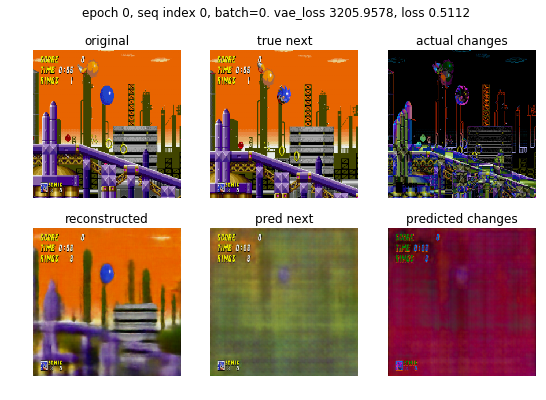

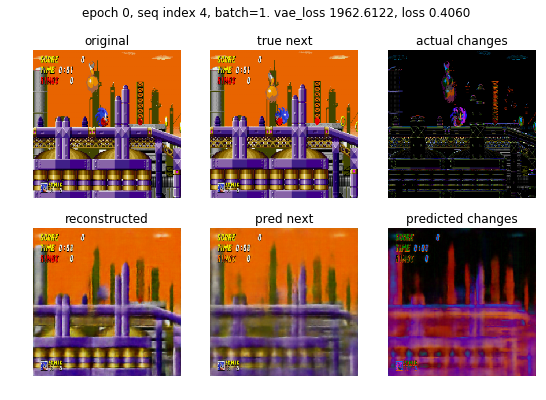

[0/1066] loss_rnn=0.1233, loss_inv= 0.05* 3.4196, loss_vae=0.0001 * (1508.79 + 0.25*|74.56 - 0|)
[400/1066] loss_rnn=0.3442, loss_inv= 0.05* 3.0774, loss_vae=0.0001 * (2531.68 + 0.25*|77.81 - 0|)
[800/1066] loss_rnn=0.3191, loss_inv= 0.05* 3.0779, loss_vae=0.0001 * (2345.15 + 0.25*|78.82 - 0|)
loss_rnn=0.3062, loss_inv= 0.05* 3.0781, loss_vae=0.0001 * (2367.37 + 0.25*|78.34 - 0|)



[0/266] loss_rnn=0.2945, loss_inv= 0.05* 3.2385, loss_vae=0.0001 * (2769.04 + 0.25*|79.68 - 0|)
loss_rnn=0.3281, loss_inv= 0.05* 3.0763, loss_vae=0.0001 * (2426.25 + 0.25*|79.69 - 0|)

Epoch 1, loss=0.3062, loss_val=0.3281, loss_vae=2386.9551, loss_vae_val=2446.1711,  loss_finv=nan, loss_finv_vae=nan, ,


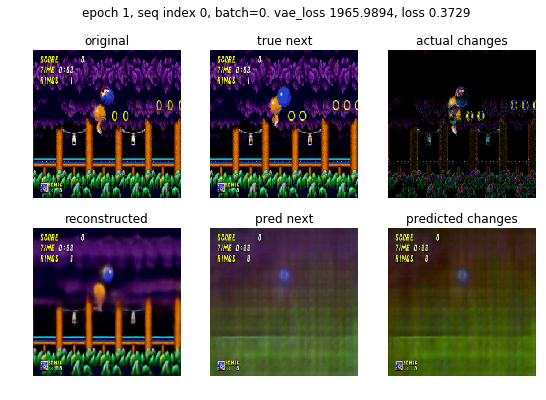

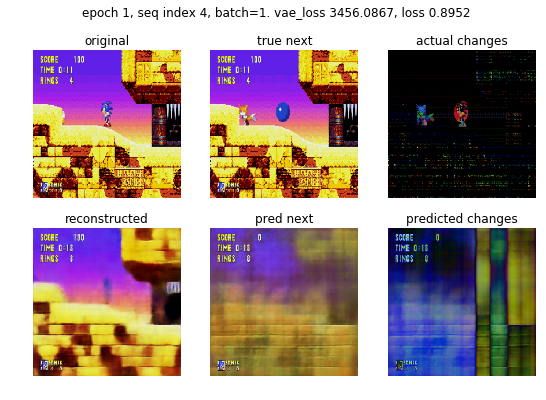

[0/1066] loss_rnn=0.4292, loss_inv= 0.05* 2.9640, loss_vae=0.0001 * (2648.13 + 0.25*|75.85 - 0|)
[400/1066] loss_rnn=0.3249, loss_inv= 0.05* 3.0786, loss_vae=0.0001 * (2355.59 + 0.25*|76.68 - 0|)
[800/1066] loss_rnn=0.3024, loss_inv= 0.05* 3.0806, loss_vae=0.0001 * (2325.95 + 0.25*|77.63 - 0|)
loss_rnn=0.3054, loss_inv= 0.05* 3.0780, loss_vae=0.0001 * (2365.41 + 0.25*|78.32 - 0|)



[0/266] loss_rnn=0.2175, loss_inv= 0.05* 3.3268, loss_vae=0.0001 * (2271.19 + 0.25*|77.46 - 0|)
loss_rnn=0.3255, loss_inv= 0.05* 3.0770, loss_vae=0.0001 * (2425.54 + 0.25*|79.67 - 0|)

Epoch 2, loss=0.3054, loss_val=0.3255, loss_vae=2384.9924, loss_vae_val=2445.4619,  loss_finv=nan, loss_finv_vae=nan, ,


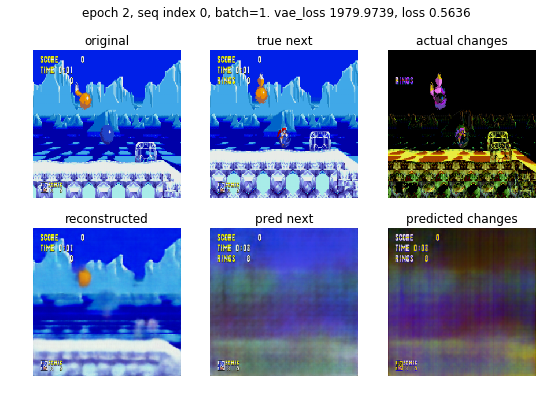

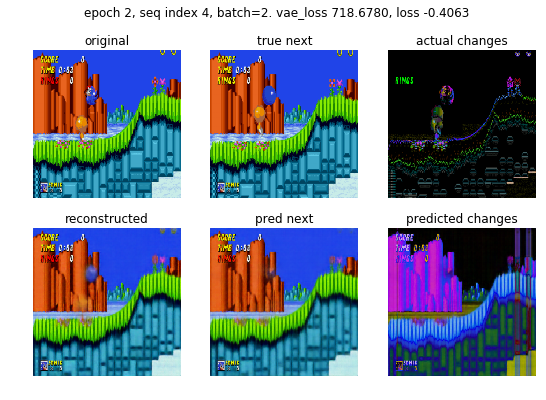

[0/1066] loss_rnn=0.3577, loss_inv= 0.05* 3.0049, loss_vae=0.0001 * (2487.54 + 0.25*|67.43 - 0|)
[400/1066] loss_rnn=0.2992, loss_inv= 0.05* 3.0760, loss_vae=0.0001 * (2126.50 + 0.25*|76.36 - 0|)
[800/1066] loss_rnn=0.2732, loss_inv= 0.05* 3.0837, loss_vae=0.0001 * (2159.54 + 0.25*|75.35 - 0|)
loss_rnn=0.3050, loss_inv= 0.05* 3.0779, loss_vae=0.0001 * (2365.16 + 0.25*|78.30 - 0|)



[0/266] loss_rnn=0.1439, loss_inv= 0.05* 2.7236, loss_vae=0.0001 * (1611.78 + 0.25*|66.99 - 0|)
loss_rnn=0.3275, loss_inv= 0.05* 3.0763, loss_vae=0.0001 * (2428.50 + 0.25*|79.71 - 0|)

Epoch 3, loss=0.3050, loss_val=0.3275, loss_vae=2384.7400, loss_vae_val=2448.4294,  loss_finv=nan, loss_finv_vae=nan, ,


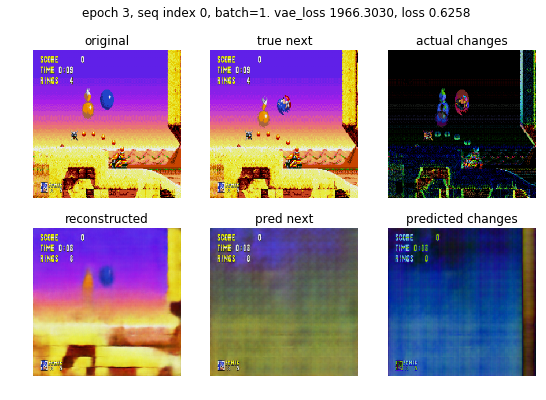

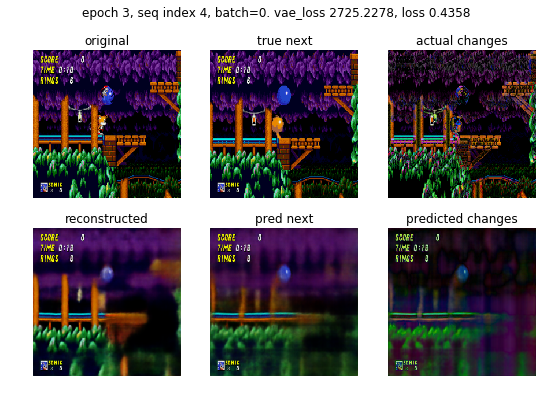

[0/1066] loss_rnn=0.5015, loss_inv= 0.05* 2.9550, loss_vae=0.0001 * (2033.94 + 0.25*|87.38 - 0|)
[400/1066] loss_rnn=0.2499, loss_inv= 0.05* 3.0868, loss_vae=0.0001 * (1900.26 + 0.25*|74.62 - 0|)
[800/1066] loss_rnn=0.2997, loss_inv= 0.05* 3.0798, loss_vae=0.0001 * (2290.97 + 0.25*|78.24 - 0|)
loss_rnn=0.3057, loss_inv= 0.05* 3.0783, loss_vae=0.0001 * (2366.01 + 0.25*|78.35 - 0|)



[0/266] loss_rnn=0.3288, loss_inv= 0.05* 2.8642, loss_vae=0.0001 * (2844.85 + 0.25*|67.28 - 0|)
loss_rnn=0.3245, loss_inv= 0.05* 3.0739, loss_vae=0.0001 * (2422.80 + 0.25*|79.66 - 0|)

Epoch 4, loss=0.3057, loss_val=0.3245, loss_vae=2385.5952, loss_vae_val=2442.7109,  loss_finv=nan, loss_finv_vae=nan, ,


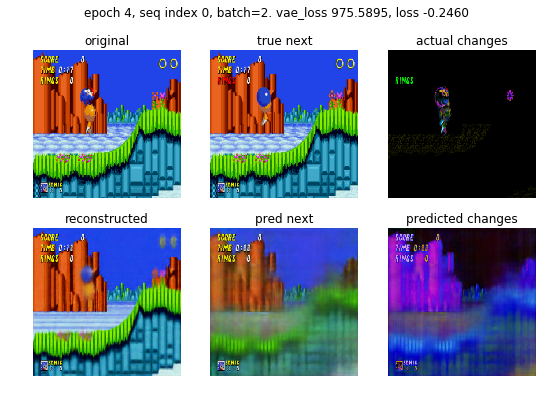

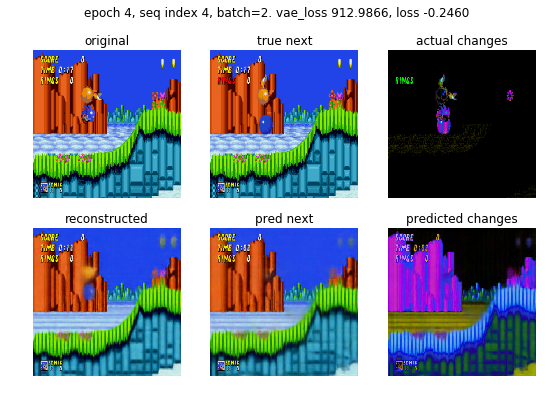

[0/1066] loss_rnn=0.2460, loss_inv= 0.05* 3.0922, loss_vae=0.0001 * (1956.31 + 0.25*|64.23 - 0|)
[400/1066] loss_rnn=0.2772, loss_inv= 0.05* 3.0944, loss_vae=0.0001 * (2009.18 + 0.25*|74.54 - 0|)
[800/1066] loss_rnn=0.3337, loss_inv= 0.05* 3.0795, loss_vae=0.0001 * (2425.92 + 0.25*|79.02 - 0|)
loss_rnn=0.3062, loss_inv= 0.05* 3.0778, loss_vae=0.0001 * (2367.02 + 0.25*|78.34 - 0|)



[0/266] loss_rnn=0.2618, loss_inv= 0.05* 3.0968, loss_vae=0.0001 * (3676.11 + 0.25*|79.41 - 0|)
loss_rnn=0.3250, loss_inv= 0.05* 3.0770, loss_vae=0.0001 * (2423.67 + 0.25*|79.67 - 0|)

Epoch 5, loss=0.3062, loss_val=0.3250, loss_vae=2386.6038, loss_vae_val=2443.5896,  loss_finv=nan, loss_finv_vae=nan, ,


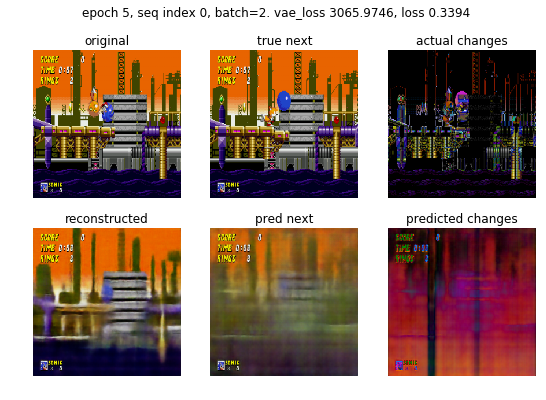

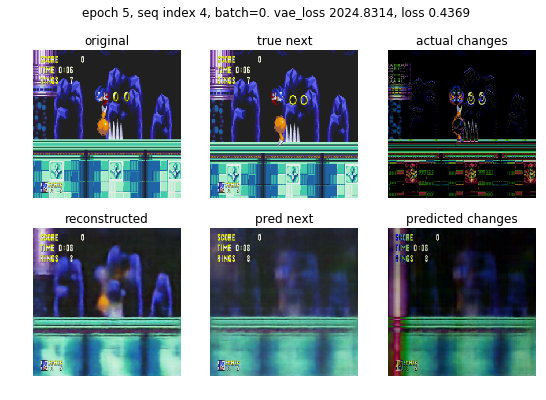

[0/1066] loss_rnn=0.1220, loss_inv= 0.05* 3.1461, loss_vae=0.0001 * (1608.44 + 0.25*|69.93 - 0|)
[400/1066] loss_rnn=0.2569, loss_inv= 0.05* 3.0749, loss_vae=0.0001 * (2013.30 + 0.25*|74.16 - 0|)
[800/1066] loss_rnn=0.3109, loss_inv= 0.05* 3.0836, loss_vae=0.0001 * (2289.59 + 0.25*|77.98 - 0|)
loss_rnn=0.3059, loss_inv= 0.05* 3.0780, loss_vae=0.0001 * (2364.66 + 0.25*|78.32 - 0|)



[0/266] loss_rnn=0.4708, loss_inv= 0.05* 3.1016, loss_vae=0.0001 * (1556.92 + 0.25*|88.80 - 0|)
loss_rnn=0.3257, loss_inv= 0.05* 3.0773, loss_vae=0.0001 * (2425.22 + 0.25*|79.71 - 0|)

Epoch 6, loss=0.3059, loss_val=0.3257, loss_vae=2384.2405, loss_vae_val=2445.1470,  loss_finv=nan, loss_finv_vae=nan, ,


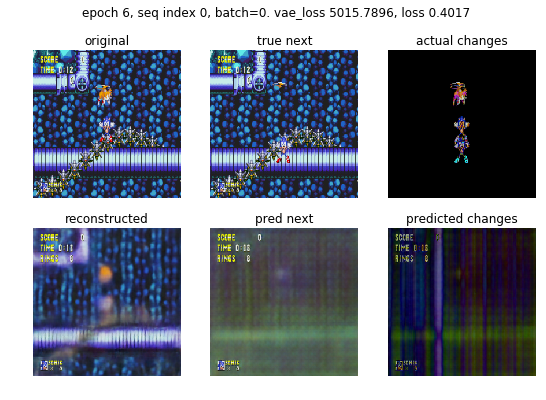

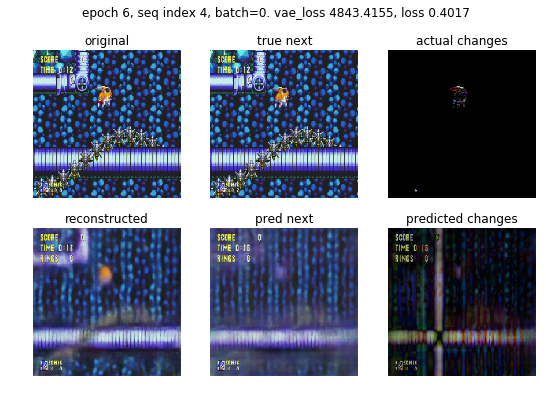

[0/1066] loss_rnn=0.2675, loss_inv= 0.05* 3.1863, loss_vae=0.0001 * (1748.57 + 0.25*|79.73 - 0|)
[400/1066] loss_rnn=0.3230, loss_inv= 0.05* 3.0996, loss_vae=0.0001 * (2274.15 + 0.25*|77.78 - 0|)
[800/1066] loss_rnn=0.2859, loss_inv= 0.05* 3.0870, loss_vae=0.0001 * (2260.11 + 0.25*|76.28 - 0|)
loss_rnn=0.3037, loss_inv= 0.05* 3.0784, loss_vae=0.0001 * (2366.90 + 0.25*|78.34 - 0|)



[0/266] loss_rnn=0.2895, loss_inv= 0.05* 2.9967, loss_vae=0.0001 * (2085.44 + 0.25*|79.62 - 0|)
loss_rnn=0.3264, loss_inv= 0.05* 3.0759, loss_vae=0.0001 * (2424.56 + 0.25*|79.73 - 0|)

Epoch 7, loss=0.3037, loss_val=0.3264, loss_vae=2386.4807, loss_vae_val=2444.4968,  loss_finv=nan, loss_finv_vae=nan, ,


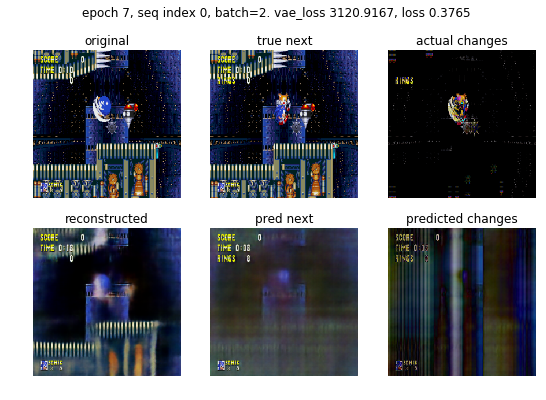

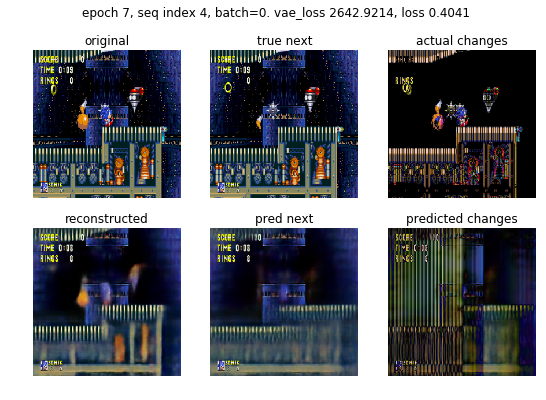

[0/1066] loss_rnn=0.3105, loss_inv= 0.05* 3.4241, loss_vae=0.0001 * (1762.08 + 0.25*|80.97 - 0|)
[400/1066] loss_rnn=0.3167, loss_inv= 0.05* 3.0724, loss_vae=0.0001 * (2378.03 + 0.25*|79.60 - 0|)
[800/1066] loss_rnn=0.3078, loss_inv= 0.05* 3.0697, loss_vae=0.0001 * (2328.43 + 0.25*|78.96 - 0|)
loss_rnn=0.3079, loss_inv= 0.05* 3.0782, loss_vae=0.0001 * (2366.79 + 0.25*|78.34 - 0|)



[0/266] loss_rnn=0.6277, loss_inv= 0.05* 3.2734, loss_vae=0.0001 * (2382.11 + 0.25*|111.28 - 0|)
loss_rnn=0.3243, loss_inv= 0.05* 3.0753, loss_vae=0.0001 * (2426.31 + 0.25*|79.67 - 0|)

Epoch 8, loss=0.3079, loss_val=0.3243, loss_vae=2386.3721, loss_vae_val=2446.2271,  loss_finv=nan, loss_finv_vae=nan, ,


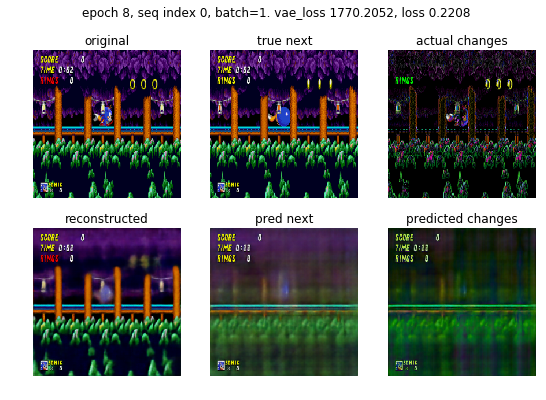

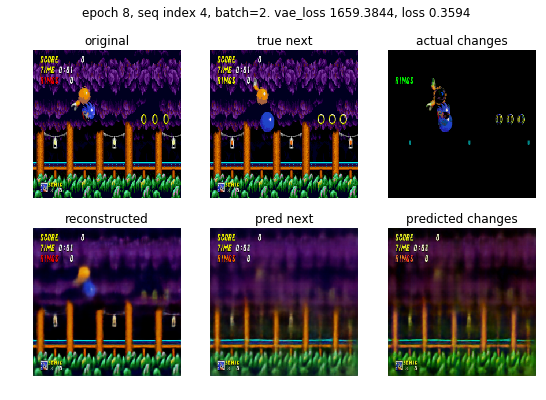

[0/1066] loss_rnn=0.5615, loss_inv= 0.05* 3.3702, loss_vae=0.0001 * (2922.16 + 0.25*|82.45 - 0|)
[400/1066] loss_rnn=0.3141, loss_inv= 0.05* 3.0779, loss_vae=0.0001 * (2503.16 + 0.25*|77.78 - 0|)
[800/1066] loss_rnn=0.3062, loss_inv= 0.05* 3.0744, loss_vae=0.0001 * (2417.48 + 0.25*|77.32 - 0|)
loss_rnn=0.3053, loss_inv= 0.05* 3.0783, loss_vae=0.0001 * (2366.67 + 0.25*|78.34 - 0|)



[0/266] loss_rnn=0.0134, loss_inv= 0.05* 3.2807, loss_vae=0.0001 * (1458.25 + 0.25*|61.77 - 0|)
loss_rnn=0.3256, loss_inv= 0.05* 3.0765, loss_vae=0.0001 * (2425.46 + 0.25*|79.66 - 0|)

Epoch 9, loss=0.3053, loss_val=0.3256, loss_vae=2386.2510, loss_vae_val=2445.3748,  loss_finv=nan, loss_finv_vae=nan, ,


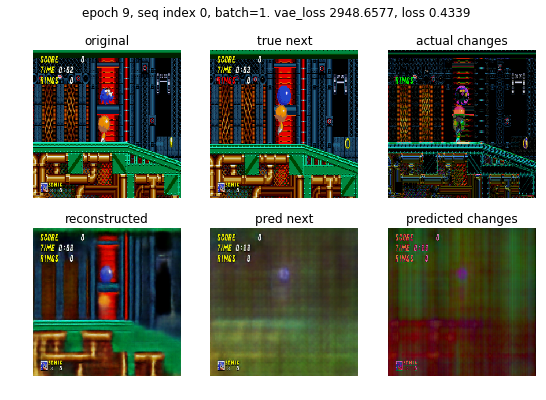

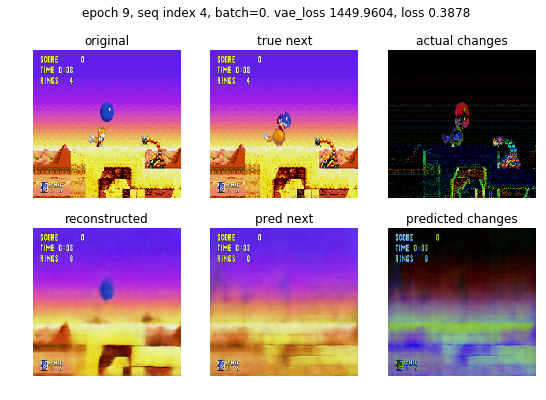

[0/1066] loss_rnn=0.4235, loss_inv= 0.05* 2.5901, loss_vae=0.0001 * (2454.33 + 0.25*|80.68 - 0|)
[400/1066] loss_rnn=0.2730, loss_inv= 0.05* 3.0712, loss_vae=0.0001 * (2228.61 + 0.25*|73.37 - 0|)
[800/1066] loss_rnn=0.3100, loss_inv= 0.05* 3.0710, loss_vae=0.0001 * (2327.34 + 0.25*|78.20 - 0|)
loss_rnn=0.3044, loss_inv= 0.05* 3.0780, loss_vae=0.0001 * (2366.58 + 0.25*|78.34 - 0|)



[0/266] loss_rnn=0.4320, loss_inv= 0.05* 3.1892, loss_vae=0.0001 * (2495.25 + 0.25*|85.10 - 0|)
loss_rnn=0.3238, loss_inv= 0.05* 3.0755, loss_vae=0.0001 * (2423.82 + 0.25*|79.68 - 0|)

Epoch 10, loss=0.3044, loss_val=0.3238, loss_vae=2386.1614, loss_vae_val=2443.7405,  loss_finv=nan, loss_finv_vae=nan, ,


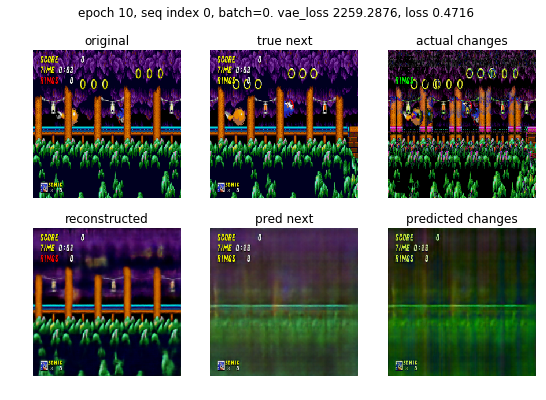

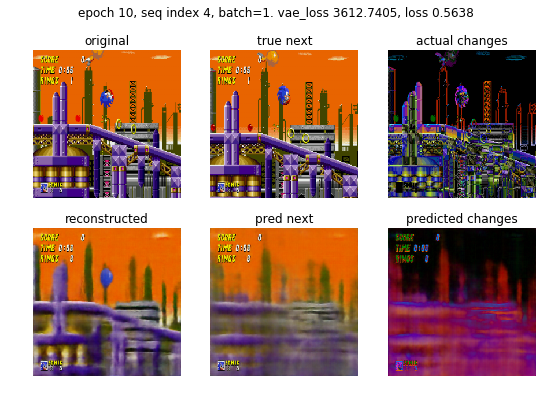

[0/1066] loss_rnn=-0.1276, loss_inv= 0.05* 3.1868, loss_vae=0.0001 * (1505.50 + 0.25*|57.22 - 0|)
[400/1066] loss_rnn=0.2826, loss_inv= 0.05* 3.0875, loss_vae=0.0001 * (2269.88 + 0.25*|75.04 - 0|)
[800/1066] loss_rnn=0.3129, loss_inv= 0.05* 3.0790, loss_vae=0.0001 * (2429.35 + 0.25*|78.69 - 0|)
loss_rnn=0.3047, loss_inv= 0.05* 3.0785, loss_vae=0.0001 * (2366.90 + 0.25*|78.34 - 0|)



[0/266] loss_rnn=0.0280, loss_inv= 0.05* 3.1369, loss_vae=0.0001 * (1946.56 + 0.25*|81.89 - 0|)
loss_rnn=0.3254, loss_inv= 0.05* 3.0767, loss_vae=0.0001 * (2425.45 + 0.25*|79.65 - 0|)

Epoch 11, loss=0.3047, loss_val=0.3254, loss_vae=2386.4819, loss_vae_val=2445.3638,  loss_finv=nan, loss_finv_vae=nan, ,


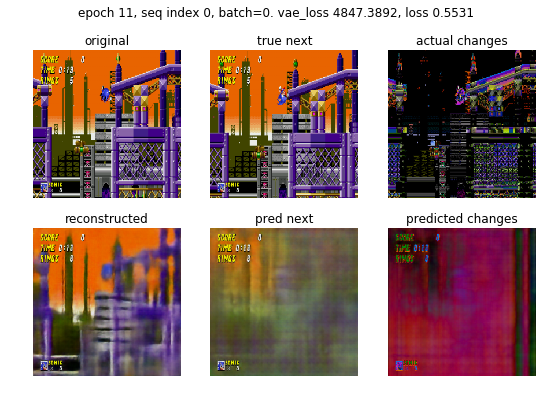

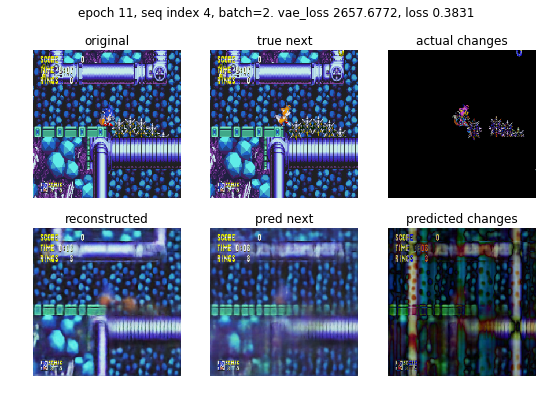

[0/1066] loss_rnn=0.1686, loss_inv= 0.05* 2.8202, loss_vae=0.0001 * (1871.40 + 0.25*|67.62 - 0|)
[400/1066] loss_rnn=0.3069, loss_inv= 0.05* 3.0540, loss_vae=0.0001 * (2336.73 + 0.25*|78.20 - 0|)
[800/1066] loss_rnn=0.3062, loss_inv= 0.05* 3.0790, loss_vae=0.0001 * (2270.41 + 0.25*|78.03 - 0|)
loss_rnn=0.3053, loss_inv= 0.05* 3.0787, loss_vae=0.0001 * (2366.31 + 0.25*|78.34 - 0|)



[0/266] loss_rnn=0.5508, loss_inv= 0.05* 2.9496, loss_vae=0.0001 * (2738.43 + 0.25*|91.18 - 0|)
loss_rnn=0.3246, loss_inv= 0.05* 3.0758, loss_vae=0.0001 * (2424.88 + 0.25*|79.65 - 0|)

Epoch 12, loss=0.3053, loss_val=0.3246, loss_vae=2385.8916, loss_vae_val=2444.7937,  loss_finv=nan, loss_finv_vae=nan, ,


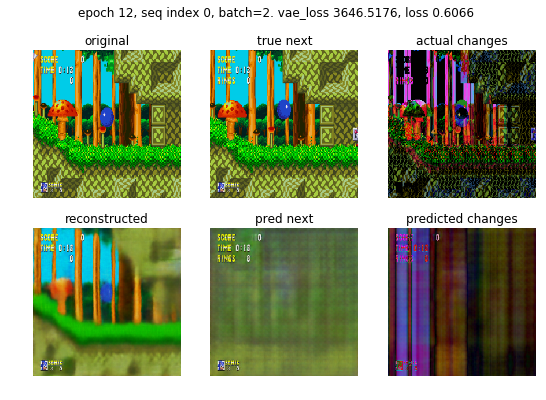

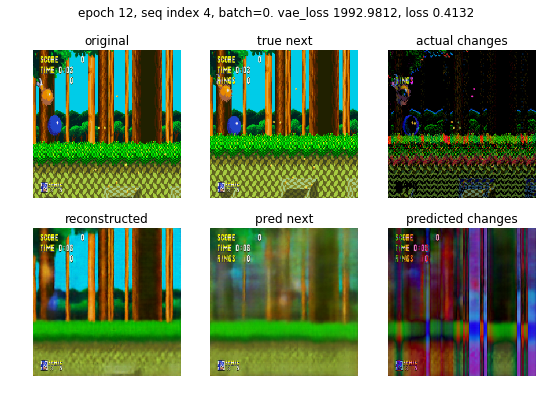

[0/1066] loss_rnn=0.2534, loss_inv= 0.05* 3.4632, loss_vae=0.0001 * (2235.10 + 0.25*|79.05 - 0|)
[400/1066] loss_rnn=0.2793, loss_inv= 0.05* 3.0849, loss_vae=0.0001 * (2100.46 + 0.25*|75.23 - 0|)
[800/1066] loss_rnn=0.3179, loss_inv= 0.05* 3.0835, loss_vae=0.0001 * (2347.02 + 0.25*|77.20 - 0|)
loss_rnn=0.3039, loss_inv= 0.05* 3.0783, loss_vae=0.0001 * (2366.75 + 0.25*|78.34 - 0|)



[0/266] loss_rnn=0.3215, loss_inv= 0.05* 3.5066, loss_vae=0.0001 * (2253.87 + 0.25*|84.98 - 0|)
loss_rnn=0.3269, loss_inv= 0.05* 3.0750, loss_vae=0.0001 * (2425.88 + 0.25*|79.68 - 0|)

Epoch 13, loss=0.3039, loss_val=0.3269, loss_vae=2386.3396, loss_vae_val=2445.8015,  loss_finv=nan, loss_finv_vae=nan, ,


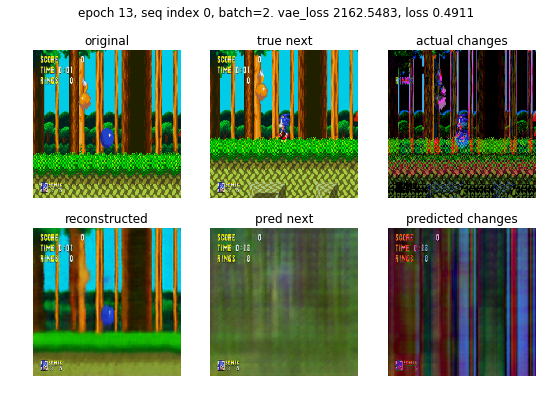

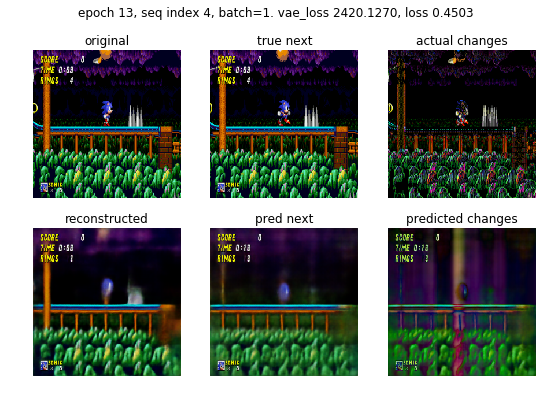

[0/1066] loss_rnn=0.3384, loss_inv= 0.05* 2.6807, loss_vae=0.0001 * (1696.29 + 0.25*|72.80 - 0|)
[400/1066] loss_rnn=0.3186, loss_inv= 0.05* 3.0688, loss_vae=0.0001 * (2488.50 + 0.25*|80.12 - 0|)
[800/1066] loss_rnn=0.3054, loss_inv= 0.05* 3.0739, loss_vae=0.0001 * (2464.42 + 0.25*|79.33 - 0|)
loss_rnn=0.3057, loss_inv= 0.05* 3.0783, loss_vae=0.0001 * (2365.66 + 0.25*|78.33 - 0|)



[0/266] loss_rnn=0.3769, loss_inv= 0.05* 3.0022, loss_vae=0.0001 * (3297.56 + 0.25*|73.55 - 0|)
loss_rnn=0.3241, loss_inv= 0.05* 3.0757, loss_vae=0.0001 * (2420.97 + 0.25*|79.63 - 0|)

Epoch    14: reducing learning rate of group 0 to 1.0000e-05.
Epoch 14, loss=0.3057, loss_val=0.3241, loss_vae=2385.2417, loss_vae_val=2440.8801,  loss_finv=nan, loss_finv_vae=nan, ,


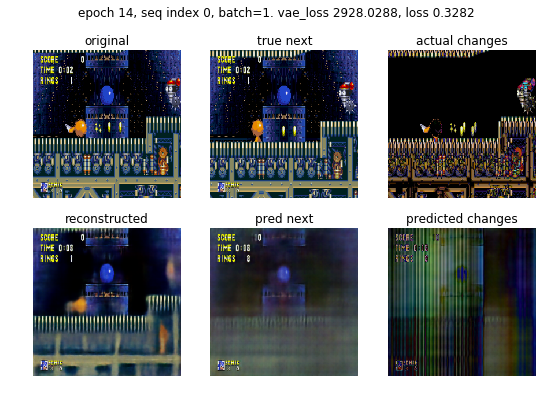

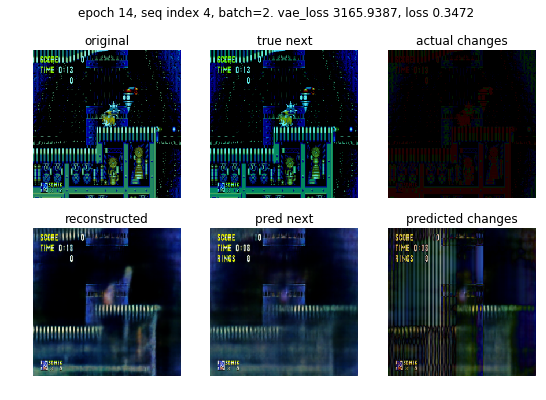

[0/1066] loss_rnn=0.6487, loss_inv= 0.05* 2.5903, loss_vae=0.0001 * (3923.02 + 0.25*|89.15 - 0|)
[400/1066] loss_rnn=0.3369, loss_inv= 0.05* 3.0784, loss_vae=0.0001 * (2414.67 + 0.25*|77.78 - 0|)
[800/1066] loss_rnn=0.2902, loss_inv= 0.05* 3.0751, loss_vae=0.0001 * (2294.47 + 0.25*|76.38 - 0|)
loss_rnn=0.3062, loss_inv= 0.05* 3.0777, loss_vae=0.0001 * (2366.98 + 0.25*|78.33 - 0|)



[0/266] loss_rnn=0.3588, loss_inv= 0.05* 2.6648, loss_vae=0.0001 * (3006.21 + 0.25*|75.69 - 0|)



KeyboardInterrupt: 

In [26]:
for epoch in range(num_epochs):
    # Run
    info = train(loader_train, vae, mdnrnn, optimizer, max_batches=max_batches, test=False, cuda=True, joint_training=True)
    torch.cuda.empty_cache()
    info_val = train(loader_test, vae, mdnrnn, optimizer, max_batches=max_batches//6, test=True, cuda=True, joint_training=True)
    torch.cuda.empty_cache()
    
    # Adjust
    scheduler.step(np.mean(info_val['loss_mdn']))
    
    # View
    print('Epoch {}, loss={:2.4f}, loss_val={:2.4f}, loss_vae={:2.4f}, loss_vae_val={:2.4f},  loss_finv={:2.4f}, loss_finv_vae={:2.4f}, ,'.format(
        epoch, 
        np.mean(info['loss_mdn']), 
        np.mean(info_val['loss_mdn']),
        np.mean(info['loss_vae']), 
        np.mean(info_val['loss_vae']),
        np.mean(info['loss_finv']),
        np.mean(info_val['loss_finv'])
    ))
    plot_results(loader_test, n=2, epoch=epoch)
    
    # Record
    history = {k+'_val':np.mean(v) for k,v in info_val.items()}
    history.update({k:np.mean(v) for k,v in info.items()})
    histories.append(history)
    
    torch.save(mdnrnn.state_dict(), f'./models/{NAME}-mdnrnn_{epoch}_state_dict.pkl')
    torch.save(vae.state_dict(), f'./models/{NAME}-vae_{epoch}_state_dict.pkl')
    torch.save(finv.state_dict(), f'./models/{NAME}-finv_{epoch}_state_dict.pkl')
    
    # Tidy
    torch.cuda.empty_cache()

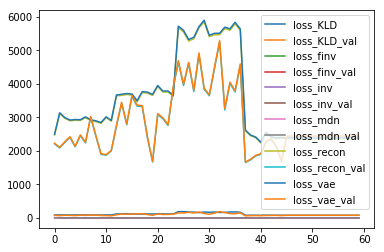

In [28]:
import pandas as pd
df_history = pd.DataFrame(histories)
df_history.plot()

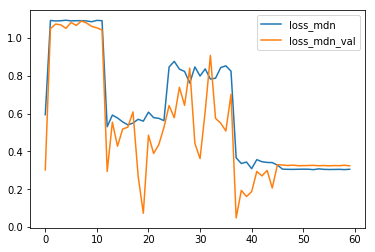

In [29]:
df_history[['loss_mdn','loss_mdn_val']].plot()

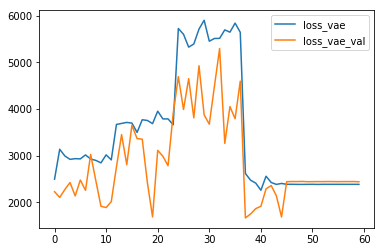

In [30]:
df_history[['loss_vae','loss_vae_val']].plot()

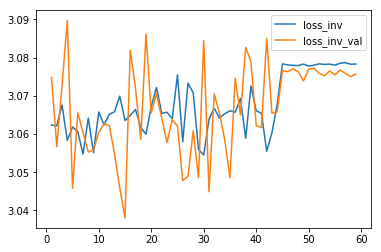

In [31]:
df_history[['loss_inv','loss_inv_val']].plot()

## Save

In [32]:
torch.save(mdnrnn.state_dict(), f'./models/{NAME}-mdnrnn_state_dict.pkl')
torch.save(vae.state_dict(), f'./models/{NAME}-vae_state_dict.pkl')
torch.save(finv.state_dict(), f'./models/{NAME}-finv_state_dict.pkl')
df_history.to_csv(f'./models/{NAME}.csv', index=False)

# torch.save(mdnrnn, f'./models/{NAME}-mdnrnn.pkl')
# torch.save(vae, f'./models/{NAME}-vae')
# torch.save(finv.state_dict(), f'./models/{NAME}-finv.pkl')

## View

In [ ]:
plot_results(loader_test, n=4, epoch=0)

In [ ]:
plot_results(loader_train, n=4, epoch=0)

In [ ]:
torch.cuda.empty_cache()